<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research_srgan_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libraries

In [12]:
import glob
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale
from skimage.metrics import peak_signal_noise_ratio as psnr

from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# importing dataset

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [14]:
pip install opencv-python-headless numpy

# Image enhancement using Traditional Method

#Nearest Neighbor Interpolation




In [15]:
def nearest_neighbor_interpolation(image, scale_factor):
    original_height, original_width = image.shape[:2]
    new_height, new_width = int(original_height * scale_factor), int(original_width * scale_factor)

    # Create an empty array for the new image
    upscaled_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)

    for i in range(new_height):
        for j in range(new_width):
            # Find the nearest neighbor in the original image
            orig_x = int(j / scale_factor)
            orig_y = int(i / scale_factor)
            upscaled_image[i, j] = image[orig_y, orig_x]

    return upscaled_image

# Path to the image dataset
dataset_path = '/content/drive/MyDrive/BSD100'

# List all files in the dataset directory
image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

# Select a random image from the dataset
random_image_file = random.choice(image_files)
image_path = os.path.join(dataset_path, random_image_file)

# Load the selected image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Perform Nearest Neighbor Interpolation
scale_factor = 2
upscaled_image = nearest_neighbor_interpolation(image, scale_factor)

# Resize the original image to match the upscaled image size for PSNR calculation
resized_original_image = cv2.resize(image, (upscaled_image.shape[1], upscaled_image.shape[0]), interpolation=cv2.INTER_LINEAR)

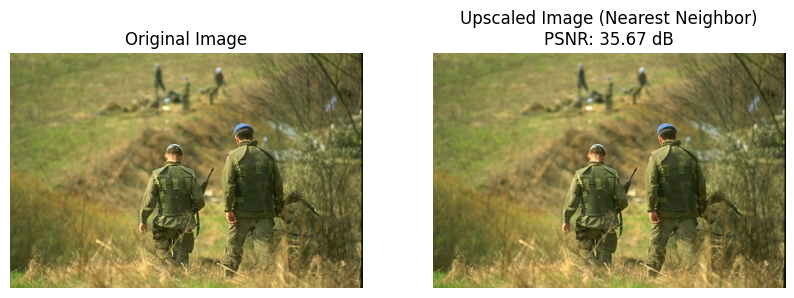

In [16]:
# Calculate PSNR between the resized original image and the upscaled image
psnr_value = psnr(resized_original_image, upscaled_image)

# Display the original and upscaled images using Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Upscaled Image (Nearest Neighbor)\nPSNR: {psnr_value:.2f} dB')
plt.imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


# Image enhancement using GAN Model

# Generator Network
commonly used in tasks like image super-resolution or image-to-image translation. Here with a combination of convolutional, residual, upsampling, and activation layers to transform input data into a desired output, such as high-resolution images.


# Discriminator Network

 discriminator network is designed to classify images as real or fake. It achieves this by applying convolutional operations to extract features from the input images and then using dense layers for classification. The use of LeakyReLU activation functions helps in preventing the network from getting stuck during training, and batch normalization aids in stabilizing the training process.


# Adversial Network
the adversarial model combines the generator, discriminator, and VGG network. The generator aims to produce high-resolution images from low-resolution inputs, while the discriminator evaluates the generated images. The VGG network helps to capture the content of the generated images. During training, the discriminator's weights are fixed to focus on improving the generator's performance.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path exists
Files in the dataset directory: ['130026.png', '101085.png', '105025.png', '123074.png', '126007.png', '108005.png', '102061.png', '106024.png', '101087.png', '108070.png', '103070.png', '119082.png', '108082.png', '109053.png', '12084.png', '21077.png', '160068.png', '16077.png', '167083.png', '223061.png', '148026.png', '253055.png', '24077.png', '241004.png', '216081.png', '175043.png', '134035.png', '227092.png', '260058.png', '167062.png', '145086.png', '147091.png', '219090.png', '170057.png', '196073.png', '163085.png', '236037.png', '148089.png', '189080.png', '208001.png', '175032.png', '143090.png', '197017.png', '19021.png', '210088.png', '182053.png', '157055.png', '253027.png', '156065.png', '229036.png', '241048.png', '220075.png', '159008.png', '14037.png', '299086.png', '86068.png', '3096.png', '285079.png', '271035.png', '65033.pn

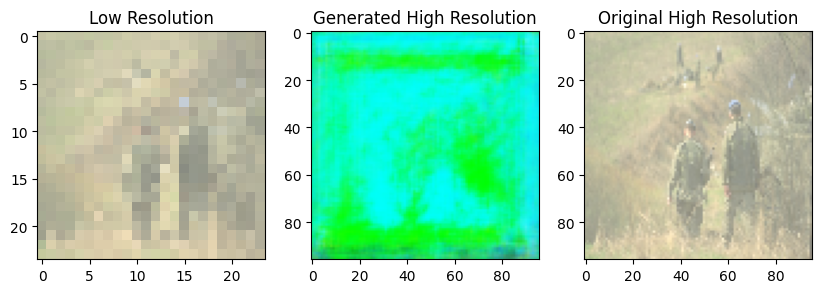

PSNR at epoch 100: 0.6818534135818481
1/1 [==============================] - 0s 37ms/step
101/1000 [D loss: 1.289289411943173e-05 | D accuracy: 100.0] [G loss: 0.06069693714380264]
1/1 [==============================] - 0s 23ms/step
102/1000 [D loss: 7.840859439056658e-06 | D accuracy: 100.0] [G loss: 0.056336477398872375]
1/1 [==============================] - 0s 33ms/step
103/1000 [D loss: 2.8864279556728434e-05 | D accuracy: 100.0] [G loss: 0.05473514273762703]
1/1 [==============================] - 0s 23ms/step
104/1000 [D loss: 4.89386957269744e-05 | D accuracy: 100.0] [G loss: 0.05116264522075653]
1/1 [==============================] - 0s 23ms/step
105/1000 [D loss: 1.362286866424256e-05 | D accuracy: 100.0] [G loss: 0.047828309237957]
1/1 [==============================] - 0s 22ms/step
106/1000 [D loss: 1.0057992199108412e-05 | D accuracy: 100.0] [G loss: 0.058503519743680954]
1/1 [==============================] - 0s 22ms/step
107/1000 [D loss: 1.4376857052411651e-05 | D accura

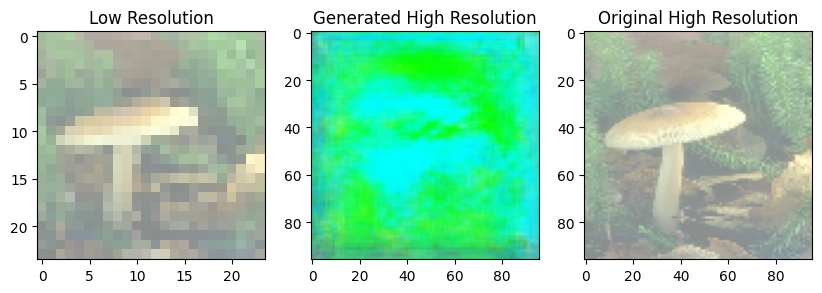

PSNR at epoch 200: 2.1265006065368652
1/1 [==============================] - 0s 22ms/step
201/1000 [D loss: 3.5800167097477242e-06 | D accuracy: 100.0] [G loss: 0.03896186500787735]
1/1 [==============================] - 0s 22ms/step
202/1000 [D loss: 4.448126958322973e-06 | D accuracy: 100.0] [G loss: 0.03861628845334053]
1/1 [==============================] - 0s 23ms/step
203/1000 [D loss: 4.629377599485451e-06 | D accuracy: 100.0] [G loss: 0.03527047857642174]
1/1 [==============================] - 0s 25ms/step
204/1000 [D loss: 1.9192100808140822e-05 | D accuracy: 100.0] [G loss: 0.048447512090206146]
1/1 [==============================] - 0s 24ms/step
205/1000 [D loss: 7.07307208358543e-06 | D accuracy: 100.0] [G loss: 0.043998755514621735]
1/1 [==============================] - 0s 42ms/step
206/1000 [D loss: 1.0929570180451265e-05 | D accuracy: 100.0] [G loss: 0.03542863950133324]
1/1 [==============================] - 0s 34ms/step
207/1000 [D loss: 6.712046001666749e-06 | D accu

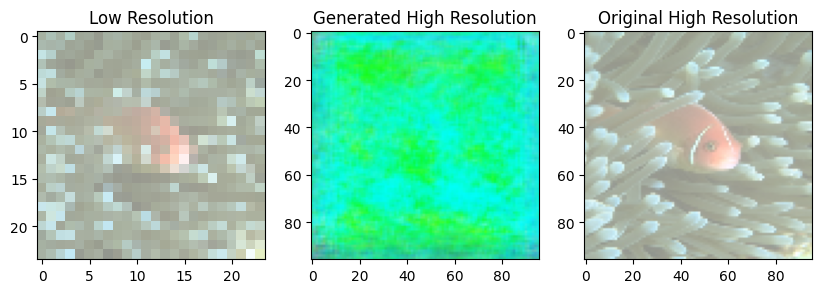

PSNR at epoch 300: 2.121044635772705
1/1 [==============================] - 0s 22ms/step
301/1000 [D loss: 1.6344236399845613e-06 | D accuracy: 100.0] [G loss: 0.028630828484892845]
1/1 [==============================] - 0s 23ms/step
302/1000 [D loss: 3.0542582862835843e-06 | D accuracy: 100.0] [G loss: 0.03162010386586189]
1/1 [==============================] - 0s 25ms/step
303/1000 [D loss: 3.6959871749786544e-06 | D accuracy: 100.0] [G loss: 0.03041745349764824]
1/1 [==============================] - 0s 36ms/step
304/1000 [D loss: 6.081867581997358e-06 | D accuracy: 100.0] [G loss: 0.027691910043358803]
1/1 [==============================] - 0s 36ms/step
305/1000 [D loss: 2.5805087489061407e-06 | D accuracy: 100.0] [G loss: 0.02937891148030758]
1/1 [==============================] - 0s 36ms/step
306/1000 [D loss: 2.678335647487984e-06 | D accuracy: 100.0] [G loss: 0.025684846565127373]
1/1 [==============================] - 0s 41ms/step
307/1000 [D loss: 2.5886536221264578e-06 | D a

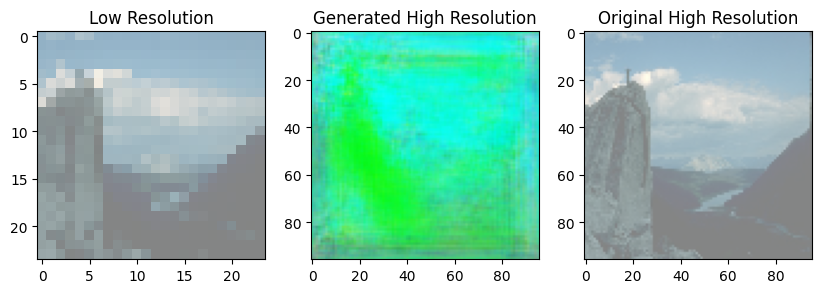

PSNR at epoch 400: 3.950399160385132
1/1 [==============================] - 0s 35ms/step
401/1000 [D loss: 2.6312011414120207e-06 | D accuracy: 100.0] [G loss: 0.02494128793478012]
1/1 [==============================] - 0s 39ms/step
402/1000 [D loss: 1.521548711025389e-06 | D accuracy: 100.0] [G loss: 0.025445330888032913]
1/1 [==============================] - 0s 38ms/step
403/1000 [D loss: 3.008484213751217e-06 | D accuracy: 100.0] [G loss: 0.02276919037103653]
1/1 [==============================] - 0s 24ms/step
404/1000 [D loss: 1.8888147934603694e-06 | D accuracy: 100.0] [G loss: 0.02375338226556778]
1/1 [==============================] - 0s 25ms/step
405/1000 [D loss: 3.2870290169739746e-06 | D accuracy: 100.0] [G loss: 0.023199858143925667]
1/1 [==============================] - 0s 29ms/step
406/1000 [D loss: 5.970814527245238e-06 | D accuracy: 100.0] [G loss: 0.03014487400650978]
1/1 [==============================] - 0s 22ms/step
407/1000 [D loss: 2.6621054871611705e-06 | D acc

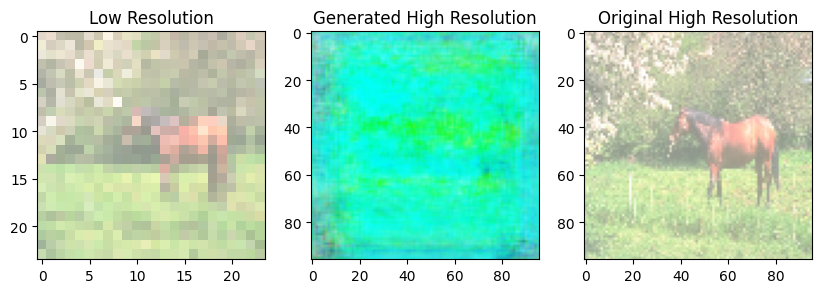

PSNR at epoch 500: 1.9288150072097778
1/1 [==============================] - 0s 27ms/step
501/1000 [D loss: 1.772079080808453e-06 | D accuracy: 100.0] [G loss: 0.02242497354745865]
1/1 [==============================] - 0s 24ms/step
502/1000 [D loss: 1.6418588124622602e-06 | D accuracy: 100.0] [G loss: 0.02137443795800209]
1/1 [==============================] - 0s 25ms/step
503/1000 [D loss: 1.3598935026948311e-06 | D accuracy: 100.0] [G loss: 0.017972558736801147]
1/1 [==============================] - 0s 24ms/step
504/1000 [D loss: 1.6776529392359407e-06 | D accuracy: 100.0] [G loss: 0.022335603833198547]
1/1 [==============================] - 0s 24ms/step
505/1000 [D loss: 4.329272421443875e-06 | D accuracy: 100.0] [G loss: 0.028033608570694923]
1/1 [==============================] - 0s 24ms/step
506/1000 [D loss: 2.0562246163535747e-06 | D accuracy: 100.0] [G loss: 0.023696618154644966]
1/1 [==============================] - 0s 23ms/step
507/1000 [D loss: 7.009462734686167e-07 | D 

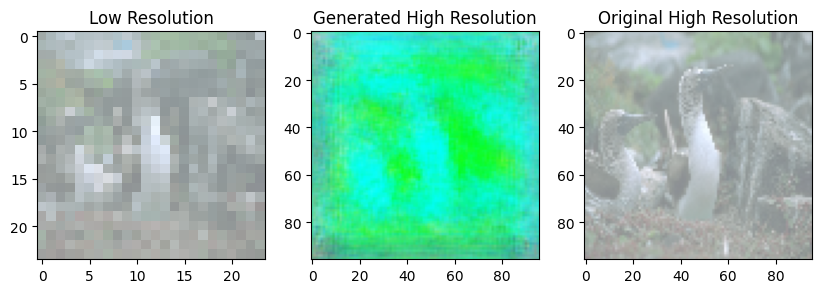

PSNR at epoch 600: 3.18319034576416
1/1 [==============================] - 0s 26ms/step
601/1000 [D loss: 8.658602874689336e-07 | D accuracy: 100.0] [G loss: 0.020035866647958755]
1/1 [==============================] - 0s 24ms/step
602/1000 [D loss: 5.84837643202718e-07 | D accuracy: 100.0] [G loss: 0.01915965974330902]
1/1 [==============================] - 0s 23ms/step
603/1000 [D loss: 1.1104814063855883e-06 | D accuracy: 100.0] [G loss: 0.017414284870028496]
1/1 [==============================] - 0s 23ms/step
604/1000 [D loss: 6.214431884643545e-07 | D accuracy: 100.0] [G loss: 0.018478678539395332]
1/1 [==============================] - 0s 36ms/step
605/1000 [D loss: 2.827394482096679e-06 | D accuracy: 100.0] [G loss: 0.022129468619823456]
1/1 [==============================] - 0s 43ms/step
606/1000 [D loss: 3.370114086465037e-06 | D accuracy: 100.0] [G loss: 0.020745037123560905]
1/1 [==============================] - 0s 40ms/step
607/1000 [D loss: 1.1184892372284594e-06 | D accu

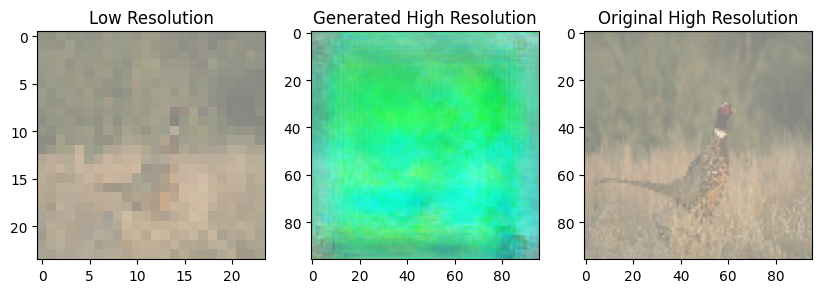

PSNR at epoch 700: 4.47127628326416
1/1 [==============================] - 0s 24ms/step
701/1000 [D loss: 1.3941725569566188e-06 | D accuracy: 100.0] [G loss: 0.01692778244614601]
1/1 [==============================] - 0s 23ms/step
702/1000 [D loss: 1.5818031897651963e-06 | D accuracy: 100.0] [G loss: 0.018766138702630997]
1/1 [==============================] - 0s 23ms/step
703/1000 [D loss: 7.808047826074471e-07 | D accuracy: 100.0] [G loss: 0.02323370799422264]
1/1 [==============================] - 0s 23ms/step
704/1000 [D loss: 8.754199711802357e-07 | D accuracy: 100.0] [G loss: 0.017462924122810364]
1/1 [==============================] - 0s 23ms/step
705/1000 [D loss: 1.7881553731058375e-06 | D accuracy: 100.0] [G loss: 0.020051611587405205]
1/1 [==============================] - 0s 34ms/step
706/1000 [D loss: 9.720485252273647e-07 | D accuracy: 100.0] [G loss: 0.016221029683947563]
1/1 [==============================] - 0s 46ms/step
707/1000 [D loss: 1.0596716890631797e-06 | D ac

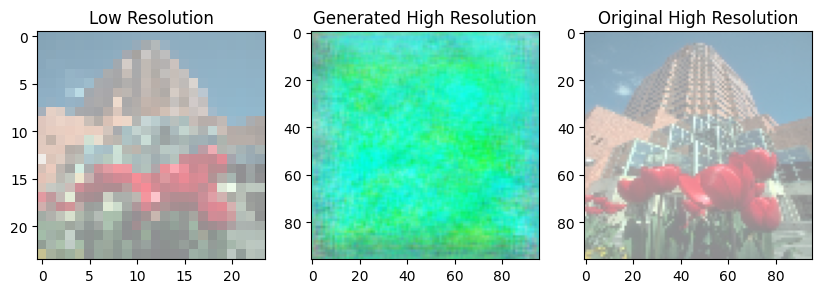

PSNR at epoch 800: 3.7589385509490967
1/1 [==============================] - 0s 23ms/step
801/1000 [D loss: 5.500892541476787e-07 | D accuracy: 100.0] [G loss: 0.014103707857429981]
1/1 [==============================] - 0s 24ms/step
802/1000 [D loss: 5.960063802490367e-07 | D accuracy: 100.0] [G loss: 0.013393915258347988]
1/1 [==============================] - 0s 23ms/step
803/1000 [D loss: 6.775364340683154e-07 | D accuracy: 100.0] [G loss: 0.01430070772767067]
1/1 [==============================] - 0s 23ms/step
804/1000 [D loss: 9.544959311824641e-07 | D accuracy: 100.0] [G loss: 0.015372266061604023]
1/1 [==============================] - 0s 23ms/step
805/1000 [D loss: 8.901516537207499e-07 | D accuracy: 100.0] [G loss: 0.014981948770582676]
1/1 [==============================] - 0s 23ms/step
806/1000 [D loss: 2.307917270627513e-06 | D accuracy: 100.0] [G loss: 0.02027430571615696]
1/1 [==============================] - 0s 22ms/step
807/1000 [D loss: 1.376086913751351e-06 | D accu

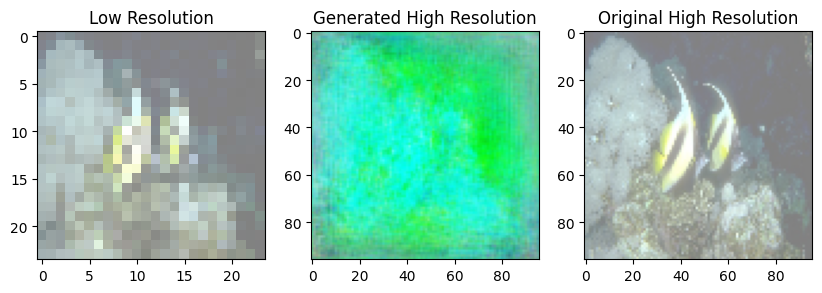

PSNR at epoch 900: 4.0757832527160645
1/1 [==============================] - 0s 24ms/step
901/1000 [D loss: 1.353035727902352e-06 | D accuracy: 100.0] [G loss: 0.014730936847627163]
1/1 [==============================] - 0s 23ms/step
902/1000 [D loss: 1.0860554766622954e-06 | D accuracy: 100.0] [G loss: 0.013201799243688583]
1/1 [==============================] - 0s 22ms/step
903/1000 [D loss: 5.547084526824619e-06 | D accuracy: 100.0] [G loss: 0.014695881865918636]
1/1 [==============================] - 0s 23ms/step
904/1000 [D loss: 1.6702807101864892e-06 | D accuracy: 100.0] [G loss: 0.016673237085342407]
1/1 [==============================] - 0s 23ms/step
905/1000 [D loss: 2.424162175884703e-06 | D accuracy: 100.0] [G loss: 0.015628870576620102]
1/1 [==============================] - 0s 39ms/step
906/1000 [D loss: 4.4073388494325627e-07 | D accuracy: 100.0] [G loss: 0.016035867854952812]
1/1 [==============================] - 0s 37ms/step
907/1000 [D loss: 5.896975272534632e-07 | D

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, PReLU, BatchNormalization, Input, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split

# Hyperparameters
lr_height = 24
lr_width = 24
lr_channels = 3
hr_height = lr_height * 4
hr_width = lr_width * 4
batch_size = 16
initial_epochs = 1000

def load_dataset(path):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            img = tf.image.decode_image(tf.io.read_file(os.path.join(path, filename)), channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)
            images.append(img)
    return images

def preprocess_image(img, hr_shape):
    img = tf.image.resize(img, hr_shape)
    return img

def build_generator():
    def residual_block(x):
        filters = 64
        r = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        r = BatchNormalization(momentum=0.8)(r)
        r = PReLU(shared_axes=[1, 2])(r)
        r = Conv2D(filters, kernel_size=3, strides=1, padding='same')(r)
        r = BatchNormalization(momentum=0.8)(r)
        return add([r, x])

    def upsample(x):
        x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = UpSampling2D(size=2)(x)
        x = PReLU(shared_axes=[1, 2])(x)
        return x

    input_layer = Input(shape=(lr_height, lr_width, lr_channels))

    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(input_layer)
    x = PReLU(shared_axes=[1, 2])(x)

    r = residual_block(x)
    for _ in range(15):
        r = residual_block(r)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
    x = BatchNormalization(momentum=0.8)(x)
    x = add([x, r])

    x = upsample(x)
    x = upsample(x)

    output_layer = Conv2D(lr_channels, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    return Model(input_layer, output_layer)

def build_discriminator():
    def d_block(layer_input, filters, strides=1, bn=True):
        d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
        d = PReLU(shared_axes=[1, 2])(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img = Input(shape=(hr_height, hr_width, lr_channels))

    d = d_block(img, 64, bn=False)
    d = d_block(d, 64, strides=2)
    d = d_block(d, 128)
    d = d_block(d, 128, strides=2)
    d = d_block(d, 256)
    d = d_block(d, 256, strides=2)
    d = d_block(d, 512)
    d = d_block(d, 512, strides=2)

    d = tf.keras.layers.Flatten()(d)
    d = tf.keras.layers.Dense(1024)(d)
    d = PReLU()(d)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(d)

    return Model(img, output_layer)

# Load VGG19 for content loss
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

def content_loss(hr, sr):
    hr = tf.image.resize(hr, (224, 224))
    sr = tf.image.resize(sr, (224, 224))
    hr_features = vgg(hr)
    sr_features = vgg(sr)
    return tf.keras.losses.MeanSquaredError()(hr_features, sr_features)

def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

# Build generator, discriminator, and combined model
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss=adversarial_loss, optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

hr = Input(shape=(hr_height, hr_width, lr_channels))
lr = Input(shape=(lr_height, lr_width, lr_channels))
sr = generator(lr)
discriminator.trainable = False
validity = discriminator(sr)
combined = Model(inputs=[lr, hr], outputs=[validity, sr])
combined.compile(loss=[adversarial_loss, content_loss], loss_weights=[1e-3, 1], optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

# Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/BSD100'
if os.path.exists(dataset_path):
    print("Path exists")
    print("Files in the dataset directory:", os.listdir(dataset_path))
else:
    print("Path does not exist")

# Load and preprocess dataset
images = load_dataset(dataset_path)
hr_images = [preprocess_image(img, (hr_height, hr_width)) for img in images]
lr_images = [tf.image.resize(img, (lr_height, lr_width)) for img in hr_images]

# Split data into training and validation sets
train_hr_images, val_hr_images, train_lr_images, val_lr_images = train_test_split(hr_images, lr_images, test_size=0.2, random_state=42)

# Early stopping and learning rate scheduler callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


# Initialize empty list to store PSNR values
psnr_values = []

# Custom training loop with early stopping and learning rate scheduler
for epoch in range(initial_epochs):
    idx = np.random.randint(0, len(train_hr_images), batch_size)
    lr_imgs = np.array([train_lr_images[i] for i in idx])
    hr_imgs = np.array([train_hr_images[i] for i in idx])

    fake_imgs = generator.predict(lr_imgs)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(hr_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch([lr_imgs, hr_imgs], [real_labels, hr_imgs])

    print(f"{epoch}/{initial_epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss[0]}]")

    # Calculate PSNR and store the value
    if epoch % 100 == 0 and epoch != 0:
        val_idx = random.randint(0, len(val_hr_images) - 1)
        test_lr = np.expand_dims(val_lr_images[val_idx], axis=0)
        test_hr = np.expand_dims(val_hr_images[val_idx], axis=0)
        generated_hr = generator.predict(test_lr)

        psnr_value = tf.image.psnr(test_hr, generated_hr, max_val=1.0).numpy()[0]
        psnr_values.append(psnr_value)

        print(f"PSNR at epoch {epoch}: {psnr_value}")

        # Save model weights (optional)
        generator.save(f'generator_epoch_{epoch}.h5')
        discriminator.save(f'discriminator_epoch_{epoch}.h5')

        # Plot PSNR values
        plt.figure(figsize=(10, 6))
        plt.plot(range(100, epoch + 1, 100), psnr_values, marker='o', linestyle='-', color='b', label='PSNR')
        plt.title('PSNR Values')
        plt.xlabel('Epoch')
        plt.ylabel('PSNR')
        plt.legend()
        plt.grid(True)
        plt.show()


In [24]:
import seaborn as sns

# Plotting PSNR values with Seaborn
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=psnr_values, marker='o', label='PSNR')
plt.title('PSNR Values')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()


NameError: name 'psnr_values' is not defined

<Figure size 1000x600 with 0 Axes>